# Previsão de Preços de Carros Usados

Este notebook implementa algoritmos de Machine Learning para prever os preços de carros usados baseado no dataset fornecido pela competição Kaggle.

In [4]:
import os
import sys

# Adicionar o diretório base do projeto ao sys.path
sys.path.append(os.path.abspath(".."))

# Importar bibliotecas principais
import pandas as pd

from scripts.evaluate import evaluate_model
from scripts.preprocessing import preprocess_data
from scripts.train_model import train_models

# Carregar os dados
train_data = pd.read_csv("../data/train.csv")
test_data = pd.read_csv("../data/test.csv")

# Pré-processamento
X_train, y_train, X_val, y_val, X_test = preprocess_data(
    train_data, test_data, target_column="price", test_size=0.8
)

# Treinamento de modelos
models = train_models(X_train, y_train)

# Encontrar o melhor modelo com base no menor RMSE
best_model_name = min(models, key=lambda x: models[x]["cv_rmse"])
best_model_info = models[best_model_name]
best_model = best_model_info["model"]

print(f"Melhor modelo: {best_model_name}")
print(f"Parâmetros ótimos: {best_model_info.get('best_params', 'N/A')}")
print(f"Cross-Validated RMSE: {best_model_info['cv_rmse']:.4f}")

# Avaliação do melhor modelo
if X_val is not None and y_val is not None:
    print("\nResultados no conjunto de validação:")
    evaluate_model(best_model, X_val, y_val)
else:
    print("\nResultados no conjunto de treino (sem validação):")
    evaluate_model(best_model, X_train, y_train)

# Submissão (usando o melhor modelo)
predictions = best_model.predict(X_test)
submission = pd.DataFrame(
    {
        "id": test_data["id"],
        "price": predictions,
    }
)

submission.to_csv("submission.csv", index=False)
print("Submissão guardada como 'submission.csv'.")

Melhor modelo: Random Forest
Parâmetros ótimos: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}
Cross-Validated RMSE: 25618.0233

Resultados no conjunto de validação:
RMSE: 25660.6447
R²: 0.4265
Submissão guardada como 'submission.csv'.


# Introdução ao código
Esta célula importa as bibliotecas necessárias para realizar a análise e manipulação de dados, a criação de gráficos e a integração de módulos personalizados no projeto. A biblioteca matplotlib e o seaborn serão utilizados posteriormente para criar visualizações dos dados. O caminho relativo do projeto é adicionado ao sys.path para facilitar a importação de módulos.

In [5]:
# Importação das bibliotecas necessárias
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Adicionar o diretório base do projeto ao sys.path para facilitar a importação de módulos personalizados
sys.path.append(os.path.abspath(".."))

from scripts.evaluate import evaluate_model
from scripts.preprocessing import preprocess_data
from scripts.train_model import train_models

# Importação Dados

Aqui, carregamos os conjuntos de dados de treino e teste. O dataset de treino contém as amostras que usaremos para ajustar os nossos modelos, enquanto o dataset de teste será utilizado para realizar previsões após o treinamento. A função **head()** mostra as primeiras linhas para inspeção inicial.

In [6]:
# Carregar os dados
train_data = pd.read_csv("../data/train.csv")
test_data = pd.read_csv("../data/test.csv")

# Visualizar as primeiras linhas dos dados de treino
train_data.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


#  Visualização Exploratória de Dados (EDA)

Este gráfico mostra a distribuição de preços no conjunto de treino, permitindo verificar se os dados estão concentrados numa faixa específica ou se existem outliers (valores atípicos) que possam afetar os resultados.

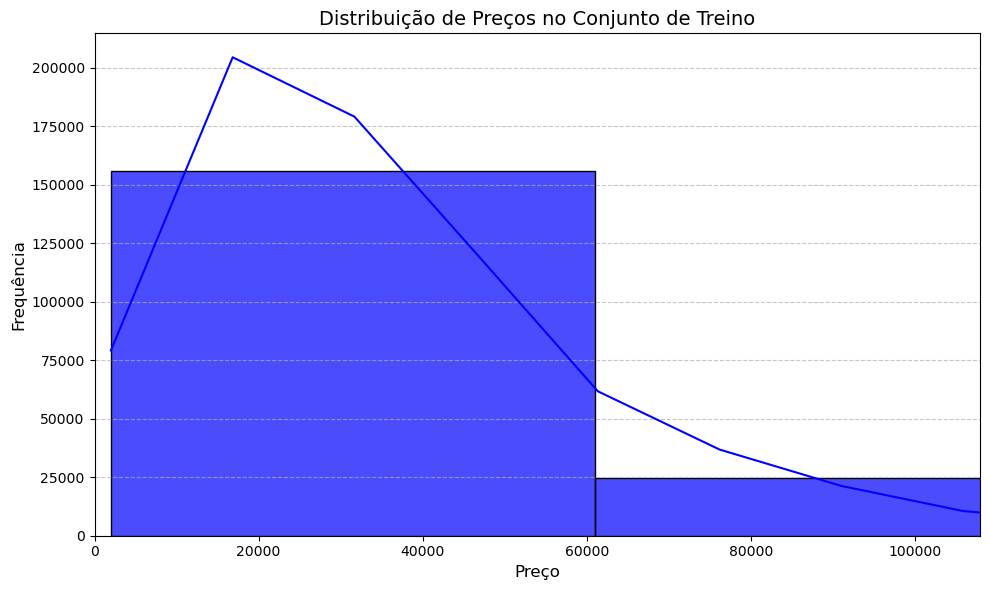

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Carregar os dados reais
train_data = pd.read_csv("../data/train.csv")

# Configurar o estilo do gráfico
plt.figure(figsize=(10, 6))
sns.histplot(
    train_data["price"], kde=True, bins=50, color="blue", alpha=0.7, edgecolor="black"
)

# Adicionar título e rótulos aos eixos
plt.title("Distribuição de Preços no Conjunto de Treino", fontsize=14)
plt.xlabel("Preço", fontsize=12)
plt.ylabel("Frequência", fontsize=12)
plt.xlim(0, train_data["price"].quantile(0.95))
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Exibir o gráfico
plt.tight_layout()
plt.show()

# Pré-processamento dos Dados

Este mesmo código aplica o pré-processamento aos dados:

- **Trata valores ausentes (missing values):**
Lida com dados que estão ausentes no dataset, seja substituindo por valores padrões (como a média ou mediana para números) ou removendo linhas/colunas com valores ausentes.

- **Codifica variáveis categóricas:**
Converte variáveis categóricas (ex.: brand, fuel_type, etc.) num formato numérico para que os modelos de machine learning possam processá-las (usando técnicas como one-hot encoding ou label encoding).

- **Normaliza variáveis numéricas:**
Ajusta os valores das variáveis numéricas para que fiquem numa escala padronizada (como [0, 1] ou média 0 e desvio padrão 1). Isso é especialmente útil para algoritmos que são sensíveis a escalas, como regressão linear ou KNN.

- **Divide os dados de treino em treino e validação:**
80% dos dados para o conjunto de treino.
20% dos dados para o conjunto de validação.

In [8]:
# Pré-processamento dos dados
X_train, y_train, X_val, y_val, X_test = preprocess_data(
    train_data, test_data, target_column="price", test_size=0.8
)

# Verificar dimensões após o pré-processamento
print("Dimensões dos dados:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}")

Dimensões dos dados:
X_train: (37338, 89), y_train: (37338,)
X_val: (149355, 89), y_val: (149355,)
X_test: (125690, 89)


# Treinamento dos Modelos

Nesta célula:

- **Treinamos três modelos diferentes:** Random Forest, Linear Regression, e KNN.
- Avaliamos os modelos usando Cross-Validation (RMSE médio).
- Identificamos o modelo com melhor desempenho baseado no menor RMSE.

In [9]:
# Treinamento de diferentes modelos
models = train_models(X_train, y_train)

# Verificar o modelo com melhor desempenho
best_model_name = min(models, key=lambda x: models[x]["cv_rmse"])
best_model_info = models[best_model_name]
best_model = best_model_info["model"]

print(f"Melhor modelo: {best_model_name}")
print(f"Parâmetros ótimos: {best_model_info.get('best_params', 'N/A')}")
print(f"Cross-Validated RMSE: {best_model_info['cv_rmse']:.4f}")

Melhor modelo: Random Forest
Parâmetros ótimos: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}
Cross-Validated RMSE: 25618.0233


# Avaliação do Melhor Modelo

Nesta etapa, avaliamos o modelo escolhido no conjunto de validação. Os resultados incluem:

- **RMSE:** Erro médio quadrático na validação.
- **R²:** Percentagem de variação explicada pelo modelo.

In [10]:
# Avaliar o melhor modelo no conjunto de validação
if X_val is not None and y_val is not None:
    print("\nResultados no conjunto de validação:")
    evaluate_model(best_model, X_val, y_val)
else:
    print("\nResultados no conjunto de treino (sem validação):")
    evaluate_model(best_model, X_train, y_train)


Resultados no conjunto de validação:
RMSE: 25660.6447
R²: 0.4265


# Visualização dos Resultados

Criamos um gráfico para comparar o desempenho dos modelos. Quanto menor o RMSE, melhor a performance do modelo.

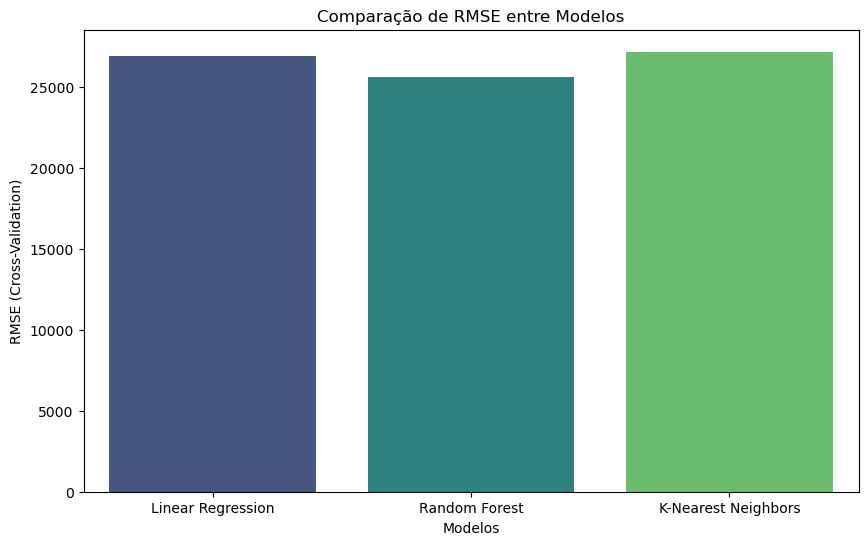

In [11]:
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

# Desativa os avisos
warnings.filterwarnings("ignore", category=FutureWarning)

# Comparação dos modelos com base no RMSE
model_names = list(models.keys())
rmse_values = [models[model]["cv_rmse"] for model in model_names]

plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=rmse_values, palette="viridis")
plt.title("Comparação de RMSE entre Modelos")
plt.ylabel("RMSE (Cross-Validation)")
plt.xlabel("Modelos")
plt.show()

# Fazer Previsões e Criar Submissão

O modelo escolhido é usado para prever os preços no conjunto de teste, e os resultados são guardados em um ficheiro CSV para submissão.

In [12]:
# Fazer previsões no conjunto de teste usando o melhor modelo
predictions = best_model.predict(X_test)

# Criar o ficheiro de submissão
submission = pd.DataFrame(
    {
        "id": test_data["id"],
        "price": predictions,
    }
)

# Guardar o ficheiro de submissão
submission.to_csv("submission.csv", index=False)
print("Submissão guardada como 'submission.csv'.")

Submissão guardada como 'submission.csv'.


# Melhor pontuação na Leaderboard do Kaggle

![Screenshot_Leaderboard.png](Screenshot_Leaderboard.png)